# Description:

    Explore options for independent filtering:
        Max rel abundance filter removes most OTUs, leaving only 270 when set to 0.005 
        Sparsity filter removes a substantial portion of OTUs, see table below for curve
        
        Final threshold: physeq.thresh = filter_taxa(physeq, 
                 function(x) sum(x > 3) > 3, TRUE)
        Protects against extremely rare OTUs, but preserves core of particular genotype 

# Setting variables

In [198]:
workDir = '/home/bryan/RhizCG/data/MiSeq_amplicon/MergedRuns/OTUexploration/'
biomFileDir = '/home/bryan/RhizCG/data/MiSeq_amplicon/MergedRuns/OTU_binning/'

biomFile = '/home/bryan/RhizCG/data/MiSeq_amplicon/MergedRuns/OTU_binning/otu_table_wtax.biom'
metadataFile = '/home/bryan/RhizCG/data/MiSeq_amplicon/metadata_RhizCG_merged.txt'
treeFile = '/home/bryan/RhizCG/data/MiSeq_amplicon/MergedRuns/fasttree/otusn.tree'

# Init

In [199]:
import os
from pandas import DataFrame
from IPython.display import FileLink

In [200]:
%matplotlib inline
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [201]:
%%R
library(vegan)
library(phyloseq)
library(ggplot2)
library(foreach)
library(doParallel)
library(gridExtra)
library(dplyr)
library(tidyr)

# Loading/editting OTU table

In [202]:
%%R -i biomFile -i metadataFile -i workDir -i treeFile
# loading
setwd(workDir)

## biom file
physeq = import_biom(biomFile, treeFile)

## loading sample metadata
sample.data = import_qiime_sample_data(metadataFile)
physeq = merge_phyloseq(physeq,sample.data)



In [203]:
%%R
#remove controls
physeq = subset_samples(physeq, !is.na(Plant))


### apply gsub across columns replacing __ w/ "" reload tax_table to phyloseq object

In [204]:
%%R
t = tax_table(physeq)
t = apply(t, 2, function(y) gsub("__", "", y))
tax_table(physeq) = t

# Explore Filtering Functions

In [270]:
%%R
median(sample_sums(physeq))

[1] 23561.5


Create a list of taxa that meet conditions 
Use list to prune_taxa

In [268]:
%%R
m = data.frame()

s = c(.001, .005, .01, .01667, .05, .1, .2)
for(i in 1:length(s)) {
    
    sparsityThresh = s[i]
    physeq.thresh = filter_taxa(physeq, 
                                function(x) sum(x > 3) >= (sparsityThresh * length(x)), TRUE)
    n = ntaxa(physeq.thresh)
    t = c(sparsityThresh,n)
    m = rbind(m,t)
    }


colnames(m) = c("sparsityThresh", "OTUcount")    
m


  sparsityThresh OTUcount
1        0.00100    11237
2        0.00500    10752
3        0.01000    10493
4        0.01667     9948
5        0.05000     8378
6        0.10000     6822
7        0.20000     5170


Filtering function
function(x): sum(x > 3) > 3, TRUE): 4986 taxa 

Below are experiments using alternate filters

## Filtering based on presence in range of samples

### Stage 1: List of taxa to passing sparsity filter

In [272]:
%%R 
physeq.thresh = filter_taxa(physeq, 
                 function(x) sum(x > 3) > (0.05*length(x)), TRUE)
physeq.thresh

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 3635 taxa and 240 samples ]
sample_data() Sample Data:       [ 240 samples by 21 sample variables ]
tax_table()   Taxonomy Table:    [ 3635 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 3635 tips and 3634 internal nodes ]


In [207]:
%%R
##use taxa_names as a list of OTUs to prune physeq object
FivePercentTaxa = taxa_names(physeq.thresh)
test = prune_taxa(FivePercentTaxa, physeq)
test

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 3635 taxa and 240 samples ]
sample_data() Sample Data:       [ 240 samples by 21 sample variables ]
tax_table()   Taxonomy Table:    [ 3635 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 3635 tips and 3634 internal nodes ]


In [208]:
%%R
str(FivePercentTaxa)

 chr [1:3635] "OTU.8680" "OTU.323" "OTU.7636" "OTU.1030" ...


### Stage 2:  List of OTUs that are in at least half of a  a fraction of a genotype's plots

In [209]:
%%R
levels(sample_data(physeq)$Plant)

 [1] "75-062" "ABUTH"  "AMAPO"  "B73"    "B97"    "BARE"   "ECHCG"  "ELCOR" 
 [9] "ERATE"  "FAGES"  "GLYMA"  "H99"    "HELAN"  "Hp301"  "Il14H"  "Ki3"   
[17] "Mo18"   "MS71"   "Oh7B"   "SETFA"  "SORBI"  "SORSUD" "Tx303" 


In [210]:
%%R

Plants = levels(sample_data(physeq)$Plant)
CoreCheck = vector()
pm = data.frame(length(Plants), 2)

for (i in 1:length(Plants)) {
    plant = Plants[i]
    physeq.p = subset_samples(physeq, Plant == plant)
    
    physeq.thresh = filter_taxa(physeq.p, 
                             function(x) sum(x > 3) > (.5 * length(x)), TRUE)

#Generate table of number of OTUs kept for each 
    n = ntaxa(physeq.thresh)
    t = c(plant,n)
    pm[i,] = t

    plantcore = taxa_names(physeq.thresh)
    CoreCheck = c(CoreCheck, plantcore)                                
    }
colnames(pm) = c("Plant", "OTUcount")

In [211]:
%%R
pm

    Plant OTUcount
1  75-062     1154
2   ABUTH      394
3   AMAPO      732
4     B73     1141
5     B97     1237
6    BARE     1608
7   ECHCG      437
8   ELCOR      380
9   ERATE     1002
10  FAGES     1265
11  GLYMA      569
12    H99      943
13  HELAN      351
14  Hp301      372
15  Il14H     1412
16    Ki3      413
17   Mo18      422
18   MS71     1637
19   Oh7B     1498
20  SETFA     1027
21  SORBI      420
22 SORSUD      407
23  Tx303      641


In [212]:
%%R
CoreList = unique(CoreCheck) 
length(CoreList)

[1] 2457


### Combine lists and use combined list to prune phyloseq object

In [213]:
%%R
TaxaList = unique(c(FivePercentTaxa, CoreList))
length(TaxaList)

[1] 3650


In [214]:
%%R
#write(TaxaList, file = "OTUs_PassedFilter.txt",
#      ncolumns = if(is.character(TaxaList)) 1 else 5,
#      append = FALSE, sep = "\t")


### Read vector and use to prune physeq object

In [215]:
#%%R
#test = read.delim(file = "OTUs_PassedFilter.txt", header = FALSE, sep = "\t")
#PruneList = as.character(test[,1])
#length(PruneList)

#Instead of reading in, use TaxaList from above
PruneList = TaxaList

[1] 3650


In [216]:
%%R
physeq.if.snorm = prune_taxa(PruneList, physeq.snorm)
physeq.if.snorm

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 3650 taxa and 240 samples ]
sample_data() Sample Data:       [ 240 samples by 21 sample variables ]
tax_table()   Taxonomy Table:    [ 3650 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 3650 tips and 3649 internal nodes ]


### Check 5% sprasity filter with add ins

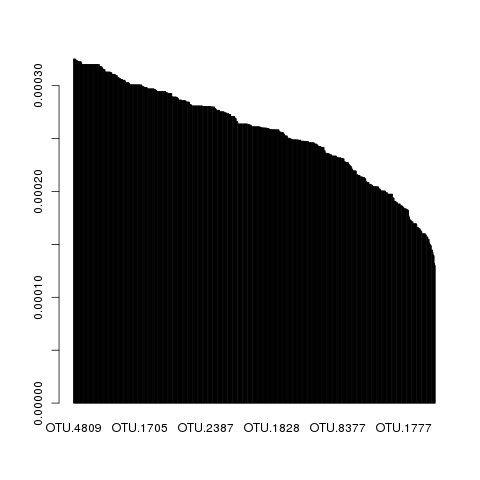

In [217]:
%%R
T = 
otu_table(physeq.if.snorm) %>%
apply(1, function(x) max(x)) %>% sort(decreasing = TRUE) 

barplot(T[3000:3650],TRUE)


In [218]:
%%R
colnames(tax_table(physeq.if.snorm)) = c("Kingdom", "Phylum",  "Class",   "Order",   
                         "Family",  "Genus",   "Species", "Strain")

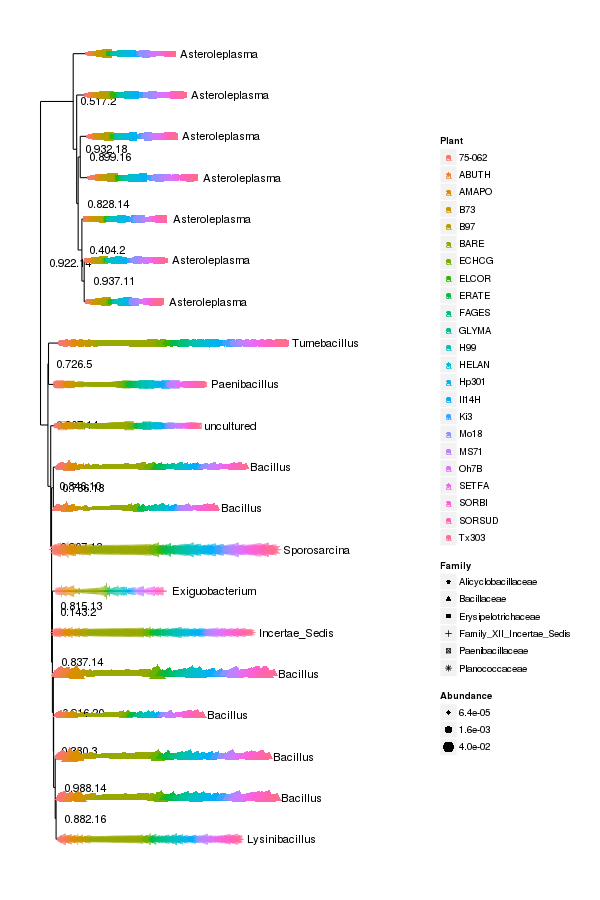

In [219]:
%%R -w 600 -h 900
Rhiz.f = subset_taxa(physeq.if.snorm, Phylum == "Firmicutes")
topNOTUs = names(sort(taxa_sums(Rhiz.f), TRUE)[1:20])
Rhiz.ft = prune_taxa(topNOTUs, Rhiz.f)
plot_tree(Rhiz.ft, color = "Plant", shape = "Family", label.tips = "Genus", 
          size = "abundance", plot.margin = 0.5, ladderize = TRUE)

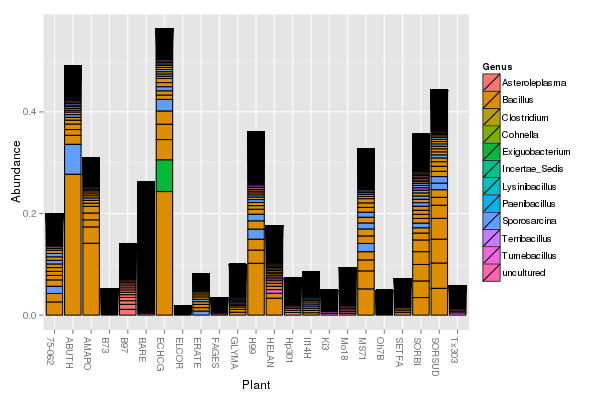

In [220]:
%%R -w 600 -h 400
p1 = plot_bar(Rhiz.f, x="Plant", fill="Genus")

#pdf("firmicutes_relabund.pdf")
p1
#dev.off()

## Filter based on max rel abundance

In [221]:
%%R
physeq.snorm

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 11246 taxa and 240 samples ]
sample_data() Sample Data:       [ 240 samples by 21 sample variables ]
tax_table()   Taxonomy Table:    [ 11246 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 11246 tips and 11245 internal nodes ]


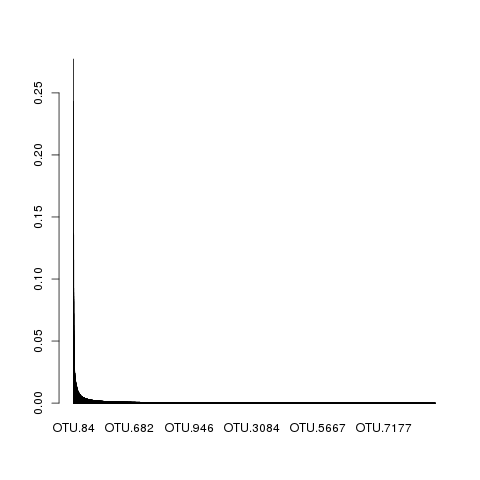

In [239]:
%%R
T = 
otu_table(physeq.snorm) %>%
apply(1, function(x) max(x)) %>% sort(decreasing = TRUE) 

barplot(T,TRUE)




In [223]:
%%R
m = data.frame()

s = c(.005, .0025, .001, .0005, .0001, .00005, .00001)
for(i in 1:length(s)) {
    
    maxThresh = s[i]
    physeq.thresh = filter_taxa(physeq.snorm, 
                            function(x) max(x) > maxThresh, TRUE)
    n = ntaxa(physeq.thresh)
    t = c(maxThresh,n)
    m = rbind(m,t)
    }


colnames(m) = c("maxThresh", "OTUcount")    
m

  maxThresh OTUcount
1   0.00500      270
2   0.00250      546
3   0.00100     1333
4   0.00050     2503
5   0.00010     8571
6   0.00005    10187
7   0.00001    11237


In [224]:
%%R

physeq.mrel.thresh = filter_taxa(physeq.snorm, 
                 function(x) max(x) > .0005, TRUE)
MaxRel = taxa_names(physeq.mrel.thresh)
length(MaxRel)

[1] 2503


### How does filtering change hypothesis testing

In terms of weighted uni-frac it does not change ordination or hypothesis testing

In [225]:
%%R
registerDoParallel(cores=28)
wunif.dist = distance(physeq.if.snorm, 
                      method = "unifrac", 
                      weighted = TRUE,
                      fast = TRUE, 
                      parallel = TRUE, 
                      normalized = FALSE)

In [226]:
%%R
registerDoParallel(cores=28)
unif.dist = distance(physeq.if.snorm, 
                      method = "unifrac", 
                      weighted = FALSE,
                      fast = TRUE, 
                      parallel = TRUE, 
                      normalized = FALSE)

### NMDS of w-Unifrac

Run 0 stress 0.1406539 
Run 1 stress 0.1820837 
Run 2 stress 0.1529288 
Run 3 stress 0.1809351 
Run 4 stress 0.1421543 
Run 5 stress 0.1807481 
Run 6 stress 0.1805535 
Run 7 stress 0.1802437 
Run 8 stress 0.1480431 
Run 9 stress 0.1525125 
Run 10 stress 0.142318 
Run 11 stress 0.1464759 
Run 12 stress 0.1406549 
... procrustes: rmse 0.00187114  max resid 0.02382739 
Run 13 stress 0.1538133 
Run 14 stress 0.1423822 
Run 15 stress 0.1428521 
Run 16 stress 0.173488 
Run 17 stress 0.1512159 
Run 18 stress 0.1515813 
Run 19 stress 0.1430067 
Run 20 stress 0.1531799 


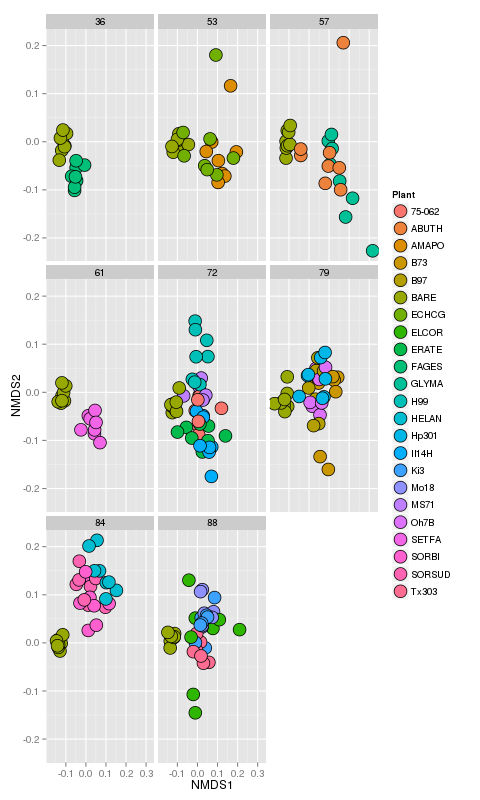

In [227]:
%%R 750 -h 800

nmds = ordinate(physeq.if.snorm, 
                method = "NMDS", 
                distance = wunif.dist)

p = plot_ordination(physeq.if.snorm, nmds, justDF = TRUE)

## generating plots
p1 = ggplot(p, aes(x = NMDS1, y = NMDS2)) +
        geom_point(aes(fill=Plant), size = 6, pch=21) +
        facet_wrap(~ DAP) +
        scale_size(range=c(2,8))

p1


### NMDS of unweighted uni-frac

Run 0 stress 0.153802 
Run 1 stress 0.1564929 
Run 2 stress 0.1533297 
... New best solution
... procrustes: rmse 0.007375299  max resid 0.05966701 
Run 3 stress 0.1740282 
Run 4 stress 0.171352 
Run 5 stress 0.1638824 
Run 6 stress 0.1553768 
Run 7 stress 0.1635418 
Run 8 stress 0.1574761 
Run 9 stress 0.1593152 
Run 10 stress 0.1565347 
Run 11 stress 0.1685086 
Run 12 stress 0.1630241 
Run 13 stress 0.1615801 
Run 14 stress 0.1635102 
Run 15 stress 0.1528417 
... New best solution
... procrustes: rmse 0.006447944  max resid 0.05931927 
Run 16 stress 0.1554832 
Run 17 stress 0.1607762 
Run 18 stress 0.1595411 
Run 19 stress 0.1647022 
Run 20 stress 0.1700387 


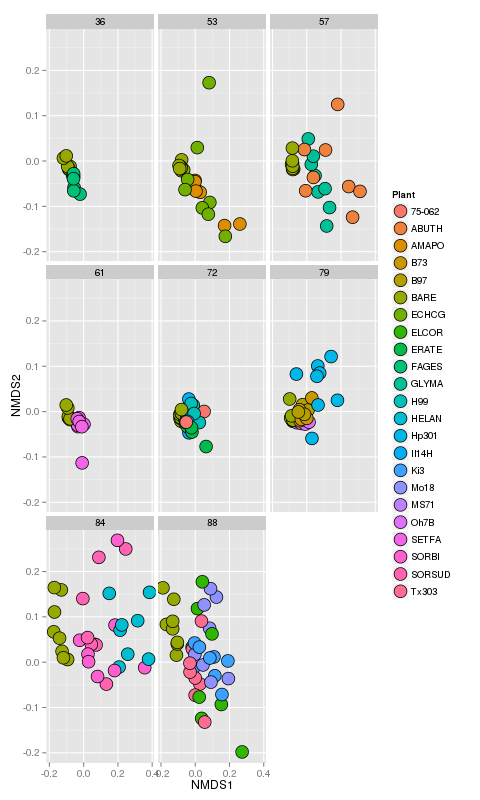

In [228]:
%%R 750 -h 800

nmds = ordinate(physeq.if.snorm, 
                method = "NMDS", 
                distance = unif.dist)

p = plot_ordination(physeq.thresh, nmds, justDF = TRUE)

## generating plots
p1 = ggplot(p, aes(x = NMDS1, y = NMDS2)) +
        geom_point(aes(fill=Plant), size = 6, pch=21) +
        facet_wrap(~ DAP) +
        scale_size(range=c(2,8))

p1

# Subset just plants to evaluate variation without bare soil

In [230]:
%%R
plant_full = subset_samples(physeq.snorm, Plant != "BARE")
sample_data(plant_full)$DAP = factor(sample_data(plant)$DAP)
plant_full

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 11246 taxa and 176 samples ]
sample_data() Sample Data:       [ 176 samples by 21 sample variables ]
tax_table()   Taxonomy Table:    [ 11246 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 11246 tips and 11245 internal nodes ]


### Create distance matrix of weighted and unweighted unifrac for each plant subset

In [231]:
%%R
registerDoParallel(cores=28)
plant.wunif.dist = distance(plant, 
                      method = "unifrac", 
                      weighted = TRUE,
                      fast = TRUE, 
                      parallel = TRUE, 
                      normalized = FALSE)

In [232]:
%%R
registerDoParallel(cores=28)
plant.unif.dist = distance(plant, 
                      method = "unifrac", 
                      weighted = FALSE,
                      fast = TRUE, 
                      parallel = TRUE, 
                      normalized = FALSE)

In [233]:
%%R
registerDoParallel(cores=28)
plant_full.unif.dist = distance(plant_full, 
                      method = "unifrac", 
                      weighted = FALSE,
                      fast = TRUE, 
                      parallel = TRUE, 
                      normalized = FALSE)

### Hypothesis test of unweighted and weighted unifrac

In [234]:
%%R
df = as(sample_data(plant), "data.frame")
d = plant.wunif.dist
plantadonis = adonis(d ~ Plant + Treatment, df)
plantadonis


Call:
adonis(formula = d ~ Plant + Treatment, data = df) 

Permutation: free
Number of permutations: 999

Terms added sequentially (first to last)

           Df SumsOfSqs  MeanSqs F.Model      R2 Pr(>F)    
Plant      21    2.2020 0.104859  7.6250 0.50480  0.001 ***
Treatment   1    0.0561 0.056105  4.0798 0.01286  0.002 ** 
Residuals 153    2.1041 0.013752         0.48234           
Total     175    4.3622                  1.00000           
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [235]:
%%R
df = as(sample_data(plant), "data.frame")
d = plant.unif.dist
plantadonis = adonis(d ~ Plant + Treatment, df)
plantadonis


Call:
adonis(formula = d ~ Plant + Treatment, data = df) 

Permutation: free
Number of permutations: 999

Terms added sequentially (first to last)

           Df SumsOfSqs  MeanSqs F.Model      R2 Pr(>F)    
Plant      21    5.2365 0.249357  2.7071 0.26854  0.001 ***
Treatment   1    0.1702 0.170220  1.8480 0.00873  0.011 *  
Residuals 153   14.0930 0.092111         0.72273           
Total     175   19.4997                  1.00000           
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [236]:
%%R
df = as(sample_data(plant_full), "data.frame")
d = plant_full.unif.dist
plantadonis = adonis(d ~ Plant + Treatment, df)
plantadonis


Call:
adonis(formula = d ~ Plant + Treatment, data = df) 

Permutation: free
Number of permutations: 999

Terms added sequentially (first to last)

           Df SumsOfSqs  MeanSqs F.Model      R2 Pr(>F)    
Plant      21    5.2365 0.249357  2.7071 0.26854  0.001 ***
Treatment   1    0.1702 0.170220  1.8480 0.00873  0.007 ** 
Residuals 153   14.0930 0.092111         0.72273           
Total     175   19.4997                  1.00000           
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


## OTUs  included in  max relative abundance bu lost in the sparsity filter

In [237]:
%%R
Sparsity = PruneList

Sparsity %>% length() %>% print
MaxRel %>% length() %>% print
print("OTUS that pass either filter")
Total = length(unique(c(Sparsity, MaxRel)))
Total


[1] 3650
[1] 2503
[1] "OTUS that pass either filter"
[1] 3893


In [241]:
%%R

otu_table(physeq.maxrel) %>%
apply(1, function(x) max(x)) %>% sort(decreasing = TRUE) 

barplot(T[3000:3650],TRUE)

[1] 0.8467404
